# Laplace Mechanism

We introduce the Laplace mechanism following [The Algorithmic Foundations of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf). Let $\mathcal X$ be the set of possible rows in a database so that we can represent a particular database by a histogram $x\in\mathbb N^{|\mathcal X|}$.

Given a particular function $f:\mathbb N^{|\mathcal X|}\rightarrow \mathbb R^k$, we define the Laplace mechanism as the collection of conditional probabilities given by

$$
p(z|x;f, b) = \prod_{i=1}^k \frac{1}{2b} e^{-\frac{1}{b}| f(x)_i - z_i| }
$$

where $z\in\mathbb R^k$. One can show that this mechanism is $\epsilon$-differentially private with $\epsilon = \frac{\Delta f}{b}$ and with the sensitivity $\Delta f$ defined as

$$
\Delta f = \underset{||x-y||_1 = 1}{\rm max} ||f(x) - f(y)||_1\,.
$$

Notice that the Laplace mechanism is a randomization algorithm that depends on the function $f$, which can be regarded as a numeric query. In order to apply this mechanism for a particular value of $\epsilon$, we need to compute $\Delta f$, which might be hard to do in practice. Furthermore, there are cases in which $\Delta f$ is unbounded so there is no way to make $\epsilon$ finite. Thus, for practical purposes, we may find a compromise and, instead of using the worst-case-scenario $\Delta f$, we can use a "typical" sensitivity. This typical sensitivity can be estimated by taking the databases $x, y$ to be random variables, which allows to compute the distribution of $||f(x) - f(y)||_1$.



# Example

We consider the case in which someone wants to estimate the mean height of a group of people. However, these do not want to reveal their exact height so they introduce some Laplacian noise to it. The first thing we need to do is decide the amount of noise they should add to their true height.

In this case, the database consists simply of one record, the height, and the function $f$ returns the height. Now, since the height is not bounded, the sensitivity $\Delta f$ is infinite. However, in practice, the height is typically not higher than 2m and is never higher than 3m. So this is a case in which the use of a typical sensitivity is in order.

The amount of noise we should introduce depends on the typical value of the height in the general population. For example, adding a noise of about 0.1cm is clearly too little. On the other hand, adding a noise of about 1m is too much, in the sense that it would be useless to compute an average height.

The distribution of heights of adult males is normal with mean $\mu_M = 178\,{\rm cm}$ and $\sigma_M = 7\,{\rm cm}$. Similarly, for females the distribution is normal with $\mu_F = 162\,{\rm cm}$ and $\sigma_F = 6.5\,{\rm cm}$. Assuming that there are the same number of males and females, the height distribution is

$$
p(h) = \frac{1}{2}\left [ \mathcal N \left (h\,|\,\mu_M, \sigma_M^2\right ) + \mathcal N\left (h\,|\,\mu_F, \sigma_F^2\right ) \right ]\,.
$$

The mean of the distribution of heights in the general population is $\mu = \frac{1}{2}(\mu_M + \mu_F)$ and the variance is given by

$$
\sigma^2 = \frac{1}{2}\left ( \sigma_M^2 + \sigma_F^2 \right ) + \frac{1}{4}\left ( \mu_M - \mu_F \right )^2\,.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shfl

Using TensorFlow backend.


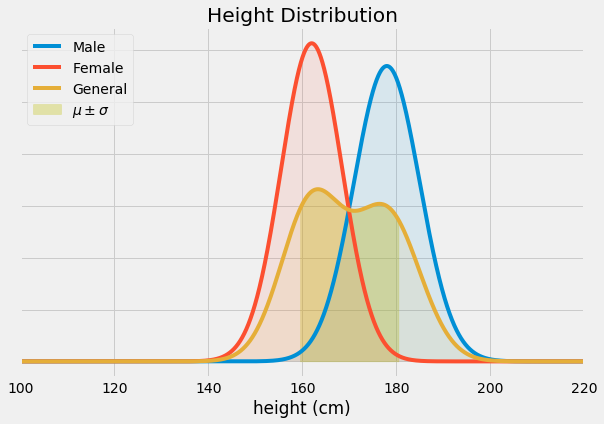

In [2]:
from scipy.stats import norm

mu_M = 178
mu_F = 162
sigma_M = 7
sigma_F = 6.5

mu = 1/2 * (mu_M + mu_F)
sigma = np.sqrt(1/2 * (sigma_M**2 + sigma_F**2) + 1/4 * (mu_M - mu_F)**2)

x = np.arange(mu - sigma, mu + sigma, 0.001) # range of x in spec
x_all = np.arange(0, 220, 0.001) # entire range of x, both in and out of spec
y = 1/2 * (norm.pdf(x, mu_M, sigma_M) + norm.pdf(x, mu_F, sigma_F))
y_M = norm.pdf(x_all, mu_M, sigma_M)
y_F = norm.pdf(x_all, mu_F, sigma_F)
y_T = 1/2 * (y_M + y_F)

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x_all, y_M, label="Male")
ax.plot(x_all, y_F, label="Female")
ax.plot(x_all, y_T, label="General")

ax.fill_between(x, y, 0, alpha=0.3, color='y', label="$\mu\pm\sigma$")
ax.fill_between(x_all, y_M, 0, alpha=0.1)
ax.fill_between(x_all, y_F, 0, alpha=0.1)
ax.fill_between(x_all, y_T, 0, alpha=0.1)
ax.set_xlim([100, 220])
ax.set_xlabel('height (cm)')
ax.set_yticklabels([])
ax.set_title('Height Distribution')
plt.legend(loc="upper left")

plt.show()

In order to estimate the typical the sensitivity, we may compute its expected value $\mathbb E[\Delta f]$. This gives

$$
\mathbb E[\Delta f] = \frac{1}{2\sqrt{\pi}}\left ( \sigma_M + \sigma_F + \sqrt{2(\sigma_M^2 + \sigma_F^2)}\left (e^{-m^2} + \sqrt{\pi}\,m \,{\rm erf}(m)\right ) \right )
$$

with $m = \frac{\mu_M - \mu_F}{\sqrt{2(\sigma_M^2 + \sigma_F^2)}}$. In principle, one could use other statistics such as $\mathbb E[\Delta f] + \sigma$ or some high percentile. Notice that, in general, it is not possible to compute the expected value (or any other statistic) of $\Delta f$ exactly. However, these can be estimated using sampling.

In [3]:
from scipy.special import erf
import math as math

m = (mu_M - mu_F)/np.sqrt((2*(sigma_M**2 + sigma_F**2)))
df = 1/(2*np.sqrt(math.pi)) * (sigma_M + sigma_F + np.sqrt(2*(sigma_M**2 + sigma_F**2)) 
                               * (np.exp(-m**2) + np.sqrt(math.pi)*m*erf(m) ) )

print("Expected sensitivity: " + str(round(df,2)) + " cm")

Expected sensitivity: 11.99 cm


The framework provides a method to sample the sensitivity in order to estimate the value without having to obtain the analytical result.

In [4]:
from shfl.private import IdentityFunction
from shfl.differential_privacy import GaussianMixture
from shfl.differential_privacy import SensitivitySampler
from shfl.differential_privacy import L1SensitivityNorm

norm_params = np.array([[mu_M, sigma_M],
                        [mu_F, sigma_F]])

weights = np.ones(2) / 2.0
distribution = GaussianMixture(norm_params, weights)

sampler = SensitivitySampler()
sensitivity, mean = sampler.sample_sensitivity(IdentityFunction(), L1SensitivityNorm(), distribution, n=1, gamma=0.05)
print("Sampled sensitivity: " + str(round(sensitivity,2)))
print("Sampled mean sensitivity: " + str(round(mean,2)))

Sampled sensitivity: 43.7
Sampled mean sensitivity: 12.04


As we can see, the value obtained is approximately the expected value for the sensitivity.

For smaller values of  𝜖 , the amount of privacy is higher, but the utility is lower. For example, if one wishes to compute the mean height over a given population, the accuracy of the result would be degraded as the amount of privacy increases. This is shown in the experiment below.

In particular, we consider a population of 500 people with a mean height $\text{true_mean}$. However, these report their heights with a Laplacian noise controlled by $\epsilon$ and the sensitivity $\Delta f$, which is then used to estimate the mean height. Wee see that as $\epsilon$ decreases, the error in this estimate increases.

In [5]:
from shfl.differential_privacy import LaplaceMechanism
from shfl.private import DataAccessDefinition

def experiment(sensitivity, epsilon):
    true_heights = np.random.normal(170, 1, 500)
    true_mean = np.mean(true_heights)
    
    federated_array = shfl.private.federated_operation.federate_array(true_heights, len(true_heights))
    
    # Define allowed access to data. 
    data_access_definition = DataAccessDefinition(dp_mechanism=LaplaceMechanism(sensitivity, epsilon))
    federated_array.configure_data_access(data_access_definition)
    
    # Query data
    result = federated_array.query()
    
    observed_mean = np.mean(result)
    error = np.abs(true_mean - observed_mean)
    
    return observed_mean, error

def run_n_experiments(sensitivity, epsilon, n_runs):
    for run in range(n_runs):
        observed_mean, error = experiment(sensitivity, epsilon)
        errors[i_df, i_epsilon] = errors[i_df, i_epsilon] + error
        
    return 1/n_runs * errors[i_df, i_epsilon]

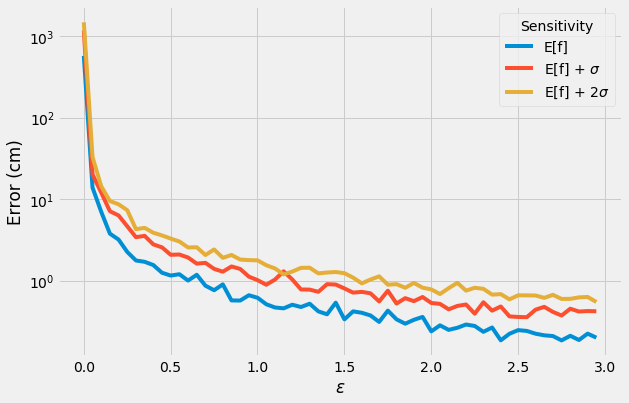

In [6]:
epsilon_range = np.arange(0.001, 3, 0.05)
df_range = df + [0, sigma, 2*sigma]
errors = np.zeros((len(df_range), len(epsilon_range)), dtype=object)

n_runs = 50
for i_df in range(len(df_range)):
    for i_epsilon in range(len(epsilon_range)):
        errors[i_df, i_epsilon] = run_n_experiments(df_range[i_df], epsilon_range[i_epsilon], n_runs)

fig, ax = plt.subplots(figsize=(9,6))
labels = ["E[f]", "E[f] + $\sigma$", "E[f] + 2$\sigma$"]
for i_df in range(len(df_range)):
    ax.plot(epsilon_range, errors[i_df], label = labels[i_df])
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('Error (cm)')
ax.set_yscale('log')
plt.legend(title = "Sensitivity", loc="upper right")
plt.show()